# Visualization of melody
In this notebook, we extract main melody from audio representation of music and experiment with spectrogram and visualization of other styles inspired by Superatism.

## 1. Spectrogram and Chromogram
One popular way of visualizing signals is spectrogram. It is a 2d representation of short-time Fourier transform (STFT) values. 

To capture the time information not available in traditional Fourier Transform, we apply short-time Fourier transform (STFT). Instead of considering the entire signal, it considers only a small section of the signal around a point t and  obtain frequency information at time = t. 

To achieve so,  we multiply the signal by the windowed function starting at t=0. Then the window function is shifted across time to apply Fourier Transform.

For a typical spectrogram, it has following elements:

* Vertical axis: frequency
* Horizontal axis: time
* Amplitude value (intensity of color): STFT value at particular frequency at particular time


### 1.1 Chromatic Scale
We first experiment with spectrogram and use the chromatic scale as a benchmark to explain the visualization

In [2]:
scales_path = "../../FMP_1/data/C3/FMP_C3_F05.wav"

Below is a chromatic scale played on a piano starting with the note A0 ( p=21 ) and ending with C8 ( p=108 ). The lowest frequency at each point in time represents the foundamental frequency of that pitch, which can be transformed into pitch number. Notice the exponential growth of the frequency values as the pitch number increases linearly in time. 

/opt/anaconda3/lib/python3.8/site-packages/scipy/io/wavfile.py:272: WavFileWarning: Chunk (non-data) not understood, skipping it.
  warnings.warn("Chunk (non-data) not understood, skipping it.",


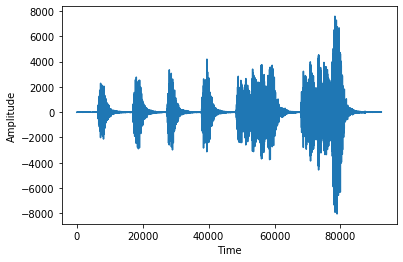

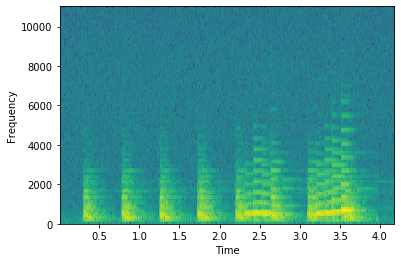

In [4]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython

samplingFrequency, signalData = wavfile.read(scales_path)

plt.plot(signalData)
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

plt.specgram(signalData,Fs=samplingFrequency)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()

IPython.display.Audio(scales_path)

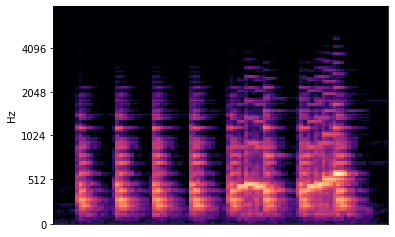

In [5]:
import librosa
import librosa.display
import numpy as np

y, sr = librosa.load(scales_path)

# Computing the mel spectrogram
spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
spect = librosa.power_to_db(spect, ref=np.max)

# Displaying the mel spectrogram 
librosa.display.specshow(spect, y_axis = 'mel', fmax = 8000)

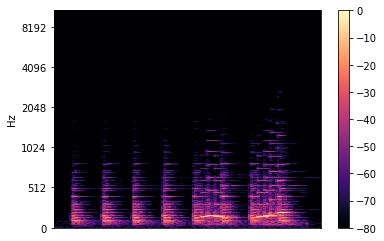

In [6]:
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db, y_axis = 'mel')
plt.colorbar()

### 1.2 Main Melody
Then we can apply spectrogram to visualize other single melody music.

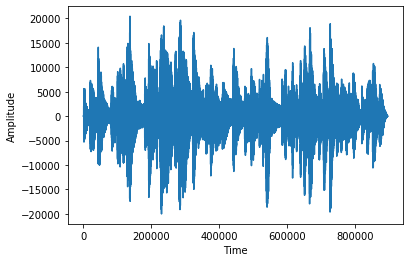

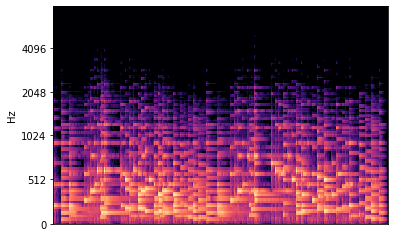

In [7]:
melody_path = "../../FMP_1/data/C3/FMP_C3S3_Schumann_Op15No7_Traeumerei_Zbinden.wav"

samplingFrequency, signalData = wavfile.read(melody_path)

plt.plot(signalData)
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

y, sr = librosa.load(melody_path)

spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
spect = librosa.power_to_db(spect, ref=np.max)

# Displaying the mel spectrogram 
librosa.display.specshow(spect, y_axis = 'mel', fmax = 8000)

IPython.display.Audio(melody_path)

## 2. Main melody extraction

/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


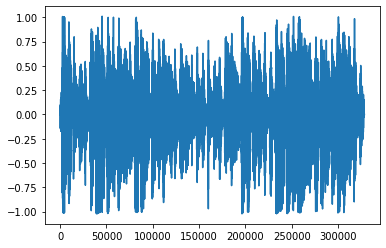

In [15]:
# melody_path = "../../FMP_1/data/C4/FMP_C4_Audio_Brahms_HungarianDances-05_FuldaSymphOrch.wav"
melody_path = "./test.mp3"

y, sr = librosa.load(melody_path)

plt.plot(y)

IPython.display.Audio(melody_path)

 0.002902494
[-440. -440. -440. ... -440. -440. -440.]


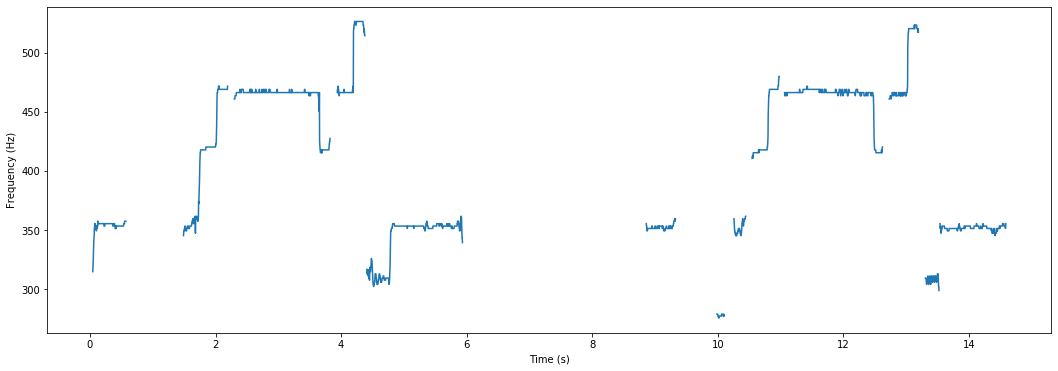

In [9]:
import vamp

data = vamp.collect(y, sr, "mtg-melodia:melodia")

hop, melody = data['vector']
print(hop)
print(melody)

timestamps = 8 * 128/44100.0 + np.arange(len(melody)) * (128/44100.0)

melody_pos = melody.copy()
melody_pos[melody<=0] = None
plt.figure(figsize=(18,6))
plt.plot(timestamps, melody_pos)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [11]:
def hz2midi(hz):
    # convert from Hz to midi note
    hz_nonneg = hz.copy()
    idx = hz_nonneg <= 0
    hz_nonneg[idx] = 1
    midi = 69 + 12*np.log2(hz_nonneg/440.)
    midi[idx] = 0

    # round
    midi = np.round(midi)

    return midi

In [28]:
from scipy.signal import medfilt

def midi_to_notes(midi, fs, hop, smooth, minduration):

    # smooth midi pitch sequence first
    if (smooth > 0):
        filter_duration = smooth  # in seconds
        filter_size = int(filter_duration * fs / float(hop))
        if filter_size % 2 == 0:
            filter_size += 1
        midi_filt = medfilt(midi, filter_size)
    else:
        midi_filt = midi
    # print(len(midi),len(midi_filt))

    notes = []
    p_prev = 0
    duration = 0
    onset = 0
    for n, p in enumerate(midi_filt):
        if p == p_prev:
            duration += 1
        else:
            # treat 0 as silence
            if p_prev > 0:
                # add note
                duration_sec = duration * hop / float(fs)
                # only add notes that are long enough
                if duration_sec >= minduration:
                    onset_sec = onset * hop / float(fs)
                    notes.append((onset_sec, duration_sec, int(p_prev)))

            # start new note
            onset = n
            duration = 1
            p_prev = p

    # add last note
    if p_prev > 0:
        # add note
        duration_sec = duration * hop / float(fs)
        onset_sec = onset * hop / float(fs)
        notes.append((onset_sec, duration_sec, p_prev))

    return notes

In [37]:
def pitch_to_name(pitch):
    octave = pitch // 12 - 1
    pitch_class = pitch % 12
    
    pitch_classes = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
    name = str(pitch_classes[pitch_class]) + str(octave)
    
    return name

In [38]:
import math
import pandas as pd

midi_pitch = hz2midi(melody)
notes = midi_to_notes(midi_pitch, 44100, 128, 0.25, 0.1)

notes_df = pd.DataFrame(notes, columns=["start","end","midi_pitch"])
notes_df["note"] = [pitch_to_name(x) for x in notes_df["midi_pitch"]]

notes_df

,start,end,midi_pitch,note
0,0.037732,0.513741,65,F4
1,1.465760,0.179955,65,F4
2,1.726984,0.264127,68,G#4
3,1.996916,1.634104,70,A#4
4,3.633923,0.281542,68,G#4
5,3.915465,0.258322,70,A#4
6,4.173787,0.182857,72,C5
7,4.374059,0.383129,63,D#4
8,4.765896,1.143583,65,F4
9,8.838095,0.467302,65,F4


In [34]:
def pitch_to_hsl(pitch):
    hsl_value = (pitch - 21) /  (108-21) * 360
    return hsl_value

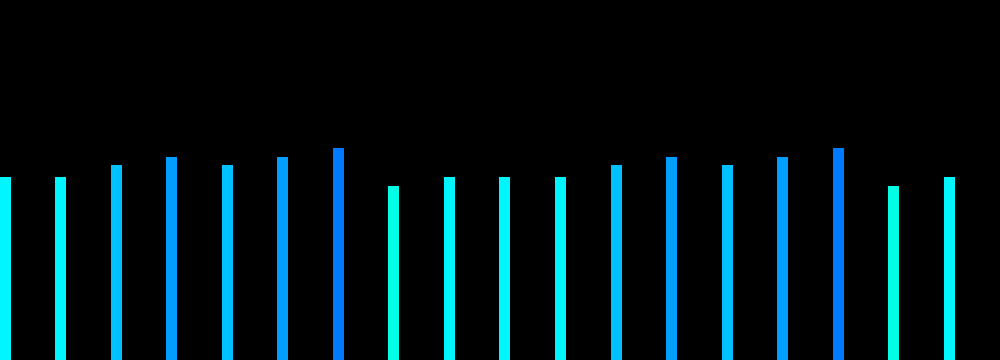

In [36]:
from PIL import Image, ImageDraw

hsl_ls = [pitch_to_hsl(x) for x in notes_df["midi_pitch"]]

w, h = 1000, 360
img = Image.new("RGB", (w, h)) 
x0, y0, x1, y1 = 0, 0, 10, 360
size = len(hsl_ls)

for i in range(size):
    img1 = ImageDraw.Draw(img)
    y0 = 360-hsl_ls[i]
    coor = [(x0, y0), (x1, y1)]
    color = "hsl({},{}%,{}%)".format(hsl_ls[i],100,50)

    img1.rectangle(coor, fill = color)
    
    x0 = x0 + w/size
    x1 = x1 + w/size

display(img)